#Datamicroscopes' DPGMMs with the Iris Dataset 

The [Iris Flower Dataset](https://archive.ics.uci.edu/ml/datasets/Iris) is a standard machine learning data set dating back to the 1930s.  It contains measurements from 150 flowers, 50 from each of the following species:

- Iris Setosa
- Iris Versicolor
- Iris Virginica

##Let's learn the latent measurements of these flowers with a DPGMM

In [84]:
import pandas as pd
from IPython.display import HTML
import seaborn as sns
import numpy as np
import pylab as plt
from microscopes.common.rng import rng
from microscopes.common.recarray.dataview import numpy_dataview
from microscopes.models import niw as normal_inverse_wishart
from microscopes.mixture.definition import model_definition
from microscopes.mixture import model, runner, query
from microscopes.common.query import zmatrix_heuristic_block_ordering, zmatrix_reorder
from functools import partial
from itertools import combinations
%matplotlib inline

In [2]:
sns.set_style('darkgrid')
sns.set_context('talk')

In [3]:
iris = sns.load_dataset('iris')
species = iris.species
covars = iris.drop('species', axis=1, inplace=False)

###Let's look at the data, both by printing the dataframe and plots

In [4]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


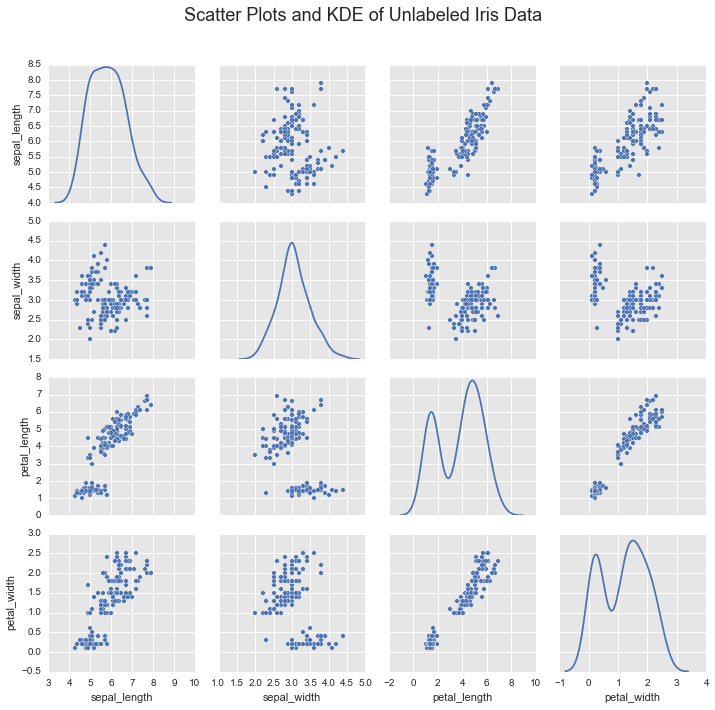

In [91]:
sns.pairplot(covars, diag_kind="kde", size=2.5)
plt.suptitle('Scatter Plots and KDE of Unlabeled Iris Data', fontsize = 18)
plt.subplots_adjust(top=.9)

###Plotting the unlabeled data suggests the possibility that the data come from two species instead of three

##How many clusters will we find using our sampler?

###Let's run samplers with various numbers of chains and iterations and plot their z-matrices to find the number of inferred clusters

In [6]:
def sampler(nchains, iters, data=covars, verbose=False, splits=3):
    '''
    defines the DPGMM model based on the data and then runs a sampler 
    with a specified number of chains and samples
    once the chains are finished, a z-matrix showing the number of clusters 
    inferred by our various samplers is plotted
    
    Parameters
    ----------
    nchains : number of markov chains 
    iters : number of iterations to run each chain
    verbose : boolean to print when a sampler has started or finished
    splits : number of data points to label on the z-matrix plot
    
    Returns
    -------
    runners : the set of completed runners object (aka the finished sampler)

    '''
    prng = rng()

    defn = model_definition(data.shape[0], [normal_inverse_wishart(data.shape[1])])

    cov_rec = np.array([(list(data.ix[c]),) for c in data.index], dtype=[('', np.float32, covars.shape[1])])
    view = numpy_dataview(cov_rec)
    latents = [model.initialize(defn, view, prng) for _ in xrange(nchains)]
    runners = [runner.runner(defn, view, latent, kernel_config=['assign']) for latent in latents]
    
    for i, rnr in enumerate(runners):
        if verbose:
            print 'starting runner %d at %d iterations' % (i, iters)
        rnr.run(r=prng, niters=iters)
        if verbose:
            print 'runner %d done' % i
    
    infers = [r.get_latent() for r in runners]
    zmat = query.zmatrix(infers)
    f, ax = plt.subplots(figsize=(12, 9))
    labels = ['%d' % i if i % (zmat.shape[0]/splits) == 0 else '' for i in xrange(zmat.shape[0])]
    sns.heatmap(zmat, linewidths=0, square=True, ax=ax, xticklabels=labels, yticklabels=labels)
    plt.title('Z-Matrix of Iris Dataset\nwith %d Chains at %d Iterations' % (nchains, iters))
    plt.ylabel('Flower Number')
    plt.ylabel('Flower Number')
    return runners

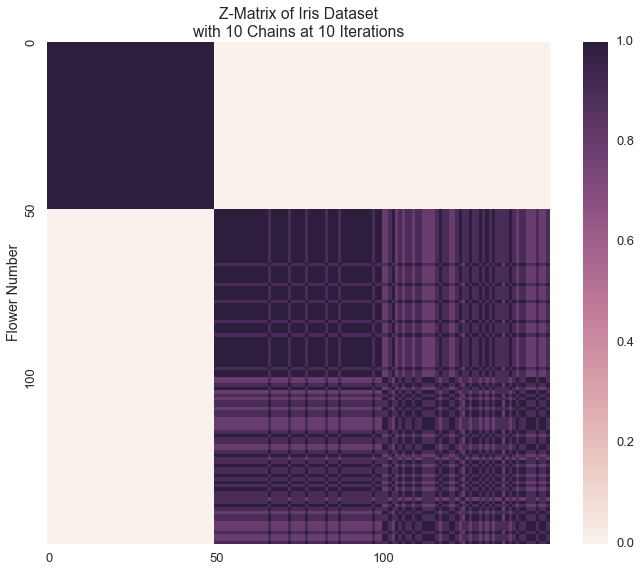

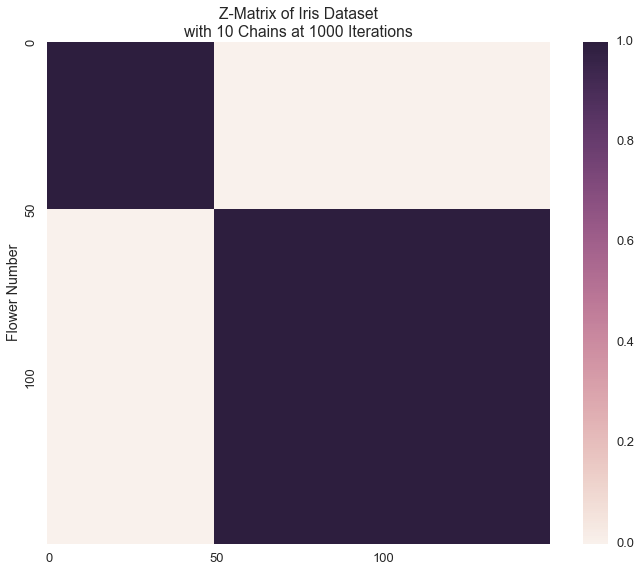

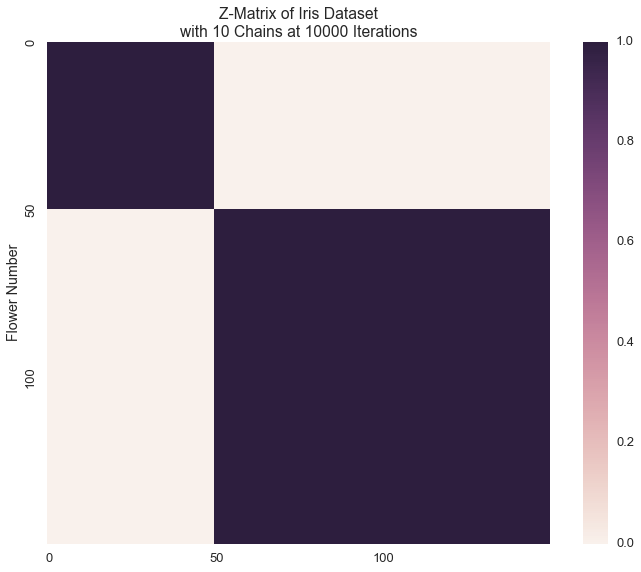

In [12]:
r10_10 = sampler(10, 10)
r10_1k = sampler(10, 1000)
r10_10k = sampler(10, 10000)

###From these 10 chains run at various iterations, it looks like they're all converging to 2 clusters

##Let's try 100 chains at 10 and 100 iterations to see if they all still agree

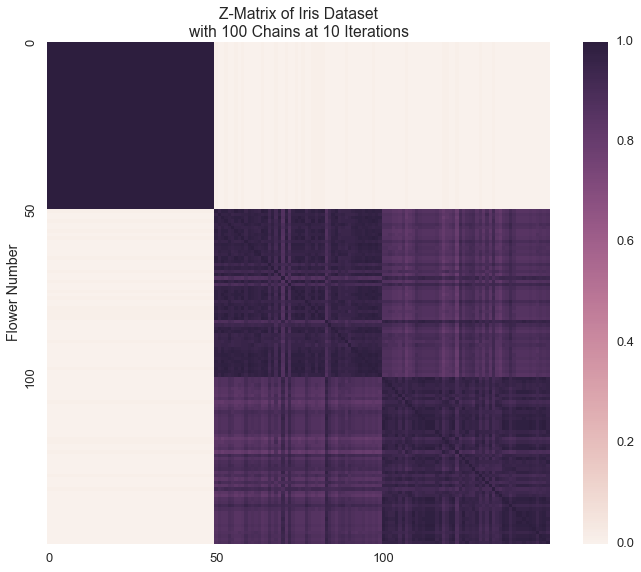

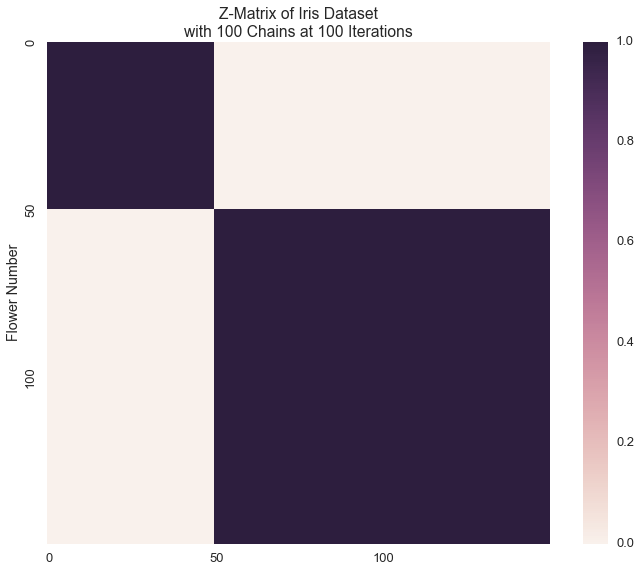

In [14]:
r100_10 = sampler(100, 10)
r100_100 = sampler(100, 100)

##Running lots of short chains doesn't separate out the data into three species

##What if we ran a few long clusters? For example 2 chains at 500,000 iterations each

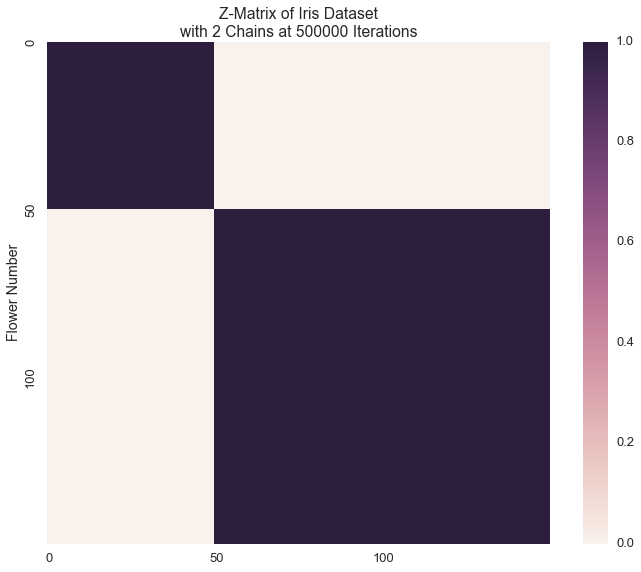

In [15]:
r2_500k = sampler(2, 500000)

##There is a strong consensus between our samplers  

##We will take one of our longer chains (since the assignments are consistent) and plot our results

##Let's move on to plotting the inferred posterior distributions

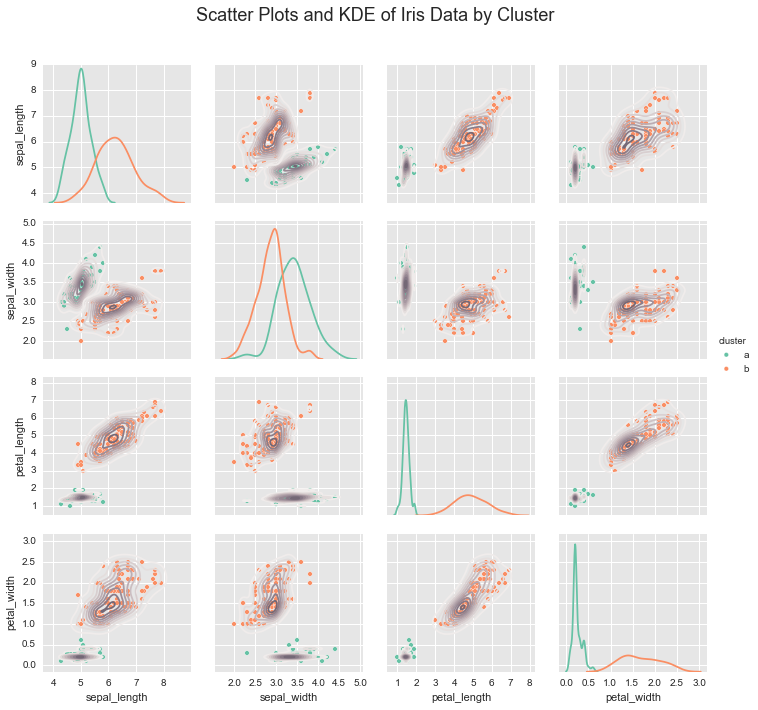

In [92]:
infers = r2_500k[0].get_latent().assignments()
covars['cluster'] = ['a' if i == sorted(list(set(infers)))[0] else 'b' for i in infers]
post = sns.pairplot(covars, hue="cluster", palette='Set2', diag_kind="kde", size=2.5)
cmap = sns.cubehelix_palette(n_colors=8, start=0, rot=0.4, gamma=0.7,
                             hue=0.2, light=0.9, dark=0.3, reverse=False, as_cmap=True)
post.map_offdiag(partial(sns.kdeplot, cmap=cmap, shade=False))
sns.set_style("darkgrid", {"grid.linewidth": .5, "axes.facecolor": ".9"})
plt.suptitle('Scatter Plots and KDE of Iris Data by Cluster', fontsize = 18)
plt.subplots_adjust(top=.9)

###Given the degree of separation between these two clusters, it's understandable that we consistently infer two clusters

#This would be a good opportunity to include prior information into the construction of our future model

Since a few of the clusters are so close together, we could select a prior value for alpha to suggest there is a higher likelihood of drawing a new cluster assignment 

Note: [Gorurl and Rasmussen 2010](http://kyb.tuebingen.mpg.de/fileadmin/user_upload/files/publications/attachments/GoeRas10_%5b0%5d.pdf) were able to infer between 3-4 clusters using a DPGMM on this dataset

##Below is a scatter plot of the ground truth cluster assignments and their kernel density estimates

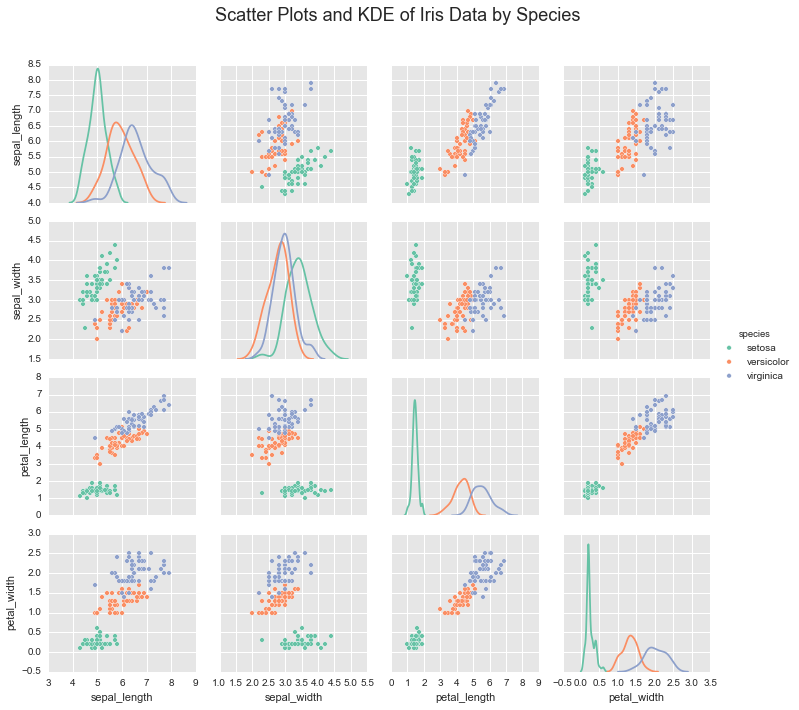

In [93]:
groundtruth = sns.pairplot(iris, hue="species", palette='Set2', diag_kind="kde", size=2.5)
groundtruth.fig.suptitle('Scatter Plots and KDE of Iris Data by Species', fontsize = 18)
groundtruth.fig.subplots_adjust(top=.9)